<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/wip/mu_lambda_ES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install scipy --upgrade

In [3]:
import random
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import qmc
from tqdm import tqdm

In [4]:
data = {}


def generate_random(number):
  values = []
  for i in range(10):
      values.extend([random.uniform(0, 1)])
  return values

#data['Betweeness'] = generate_random(10)
data['x'] = generate_random(10)
data['y'] = generate_random(10)

df = pd.DataFrame(data)
df

,x,y
0,0.398965,0.389617
1,0.373139,0.684088
2,0.013739,0.340646
3,0.908368,0.701777
4,0.844301,0.514565
5,0.905596,0.226687
6,0.369401,0.892253
7,0.973276,0.980054
8,0.810346,0.853619
9,0.463818,0.666143


mu: The number of parents selected each iteration.

lambda: Size of the population.

lambda / mu: Number of children generated from each selected parent.

In [5]:
sample = df.sample(frac=0.3, random_state=0)
sample

,x,y
2,0.013739,0.340646
8,0.810346,0.853619
4,0.844301,0.514565


In [6]:
replace = np.random.rand(sample.shape[0],sample.shape[1])
replace

array([[0.96673112, 0.07017085],
       [0.64952882, 0.16636808],
       [0.82878756, 0.59413166]])

In [7]:
df.loc[sample.index] = replace
df

,x,y
0,0.398965,0.389617
1,0.373139,0.684088
2,0.966731,0.070171
3,0.908368,0.701777
4,0.828788,0.594132
5,0.905596,0.226687
6,0.369401,0.892253
7,0.973276,0.980054
8,0.649529,0.166368
9,0.463818,0.666143


In [8]:
def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [9]:
objective(df)

0.14411296463169568

In [10]:
# check if a point is within the bounds of the search
def in_bounds(point):
	# assuming all dimensions should lie in the same range, e.i. [0,1]
	test = ((point > 0) == (point < 1)).all()
	# Returns True if they are, false otherwise.
	return test

In [21]:
# evolution strategy (mu, lambda) algorithm
def es_comma(initial_record, objective, frac, n_iter, step_size, mu, lam):
  best, best_eval = None, 1e+10
	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = df.copy()
    sample = candidate.sample(frac=frac, random_state=0)
    candidate.loc[sample.index] = np.random.rand(sample.shape[0],sample.shape[1])
    population.append(candidate)

  # perform the search
  for epoch in tqdm(range(n_iter)):
    # evaluate the fitness for the population
    scores = [objective(candidate) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        # create offspring for parent
        for j in range(n_children):
          aux = None
          while aux is None or not in_bounds(aux.to_numpy()):
            aux = population[i].sample(frac=frac)
            aux = population[i].loc[aux.index]
            aux = aux + np.random.rand(sample.shape[0],sample.shape[1]) * step_size

          population[i].loc[aux.index] = aux
          child = population[i]
          offspring.append(child)

    # replace population with children
    population = offspring

  return [best, best_eval]

In [56]:
# define the fraction to be sampled
frac = 0.5
# define the total iterations
n_iter = 5000000
# define the maximum step size
step_size = 0.0001
# number of parents selected
mu = 20
# the number of children generated by parents
lam = 1000
# perform the evolution strategy (mu, lambda) search
best, score = es_comma(df, objective, frac, n_iter, step_size, mu, lam)

  0%|          | 1/5000000 [00:00<414:47:11,  3.35it/s]

0, Best eval: = 0.06135
0, Best eval: = 0.06007
0, Best eval: = 0.05790
1, Best eval: = 0.05787


  0%|          | 11437/5000000 [00:00<02:31, 32865.25it/s]

2, Best eval: = 0.05786


100%|██████████| 5000000/5000000 [00:38<00:00, 130752.32it/s]


In [57]:
best

,x,y
0,0.402202,0.392871
1,0.085539,0.044340
2,0.578889,0.191081
3,0.911891,0.704796
4,0.166920,0.590014
5,0.910460,0.230977
6,0.372772,0.895599
7,0.976977,0.983677
8,0.480500,0.579878
9,0.280668,0.723951


In [58]:
score

0.05786165507306441

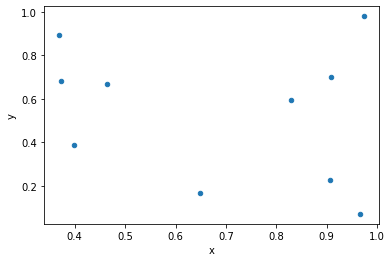

In [59]:
df.plot.scatter(x='x', y='y')

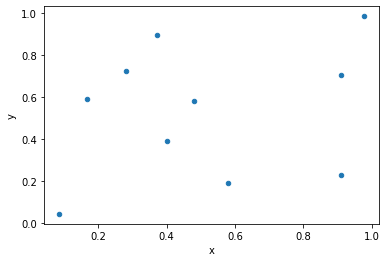

In [60]:
best.plot.scatter(x='x', y='y')